* 전통적인 모델 해석 방법론 살펴보기
* 전통적인 모델 해석 방법론의 한계 이해
* 본질적으로 해석 가능한 화이트박스 모델 살펴보기
* 성능과 해석 가능성 사이의 절충을 이해
* 새로운 해석 가능한 모델인 글래스박스 모델 발견

# 아메리칸 에어라인(AA) 정시 운항률(OTP) 분석  
* 재정적인 측면에서 지연으로 인해 항공사는 약 20억 달러에 가까운 비용 발생
* 25%-35% 정도의 지연을 줄이면 상당한 비용 절감 및 고객 만족도 증가로 티켓 판매 증가 예상
## 목표
* 2018년 국내선 도착 지연에 가장 큰 영향을 미친 요인 파악
* 2019년에는 항공사로 인한 지연을 완화하기에 충분한 정확도로 예측
* 피할 수 없는 이벤트(자연재해, 보안 이슈, 항공 교통 관제 이슈)를 제외한 공항(Hub)에서 피할 수 있는 영향 파악
* 완료



In [1]:
import math
import machine_learning_datasets as mldatasets
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics, linear_model, tree, naive_bayes, neighbors, ensemble,\
                    neural_network, svm, decomposition, manifold
from rulefit import RuleFit
import statsmodels.api as sm
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.perf import ROC
import matplotlib.pyplot as plt
import seaborn as sns

2024-01-22 00:10:38.354619: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-22 00:10:38.354637: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [2]:
import sys
#Next two lines of code only needed while CVAE
# import torch 
#remains incompatible to Tensorflow 2.2+
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()
sys.modules['tensorflow'] = tf
from cvae import cvae
#Next two lines of code only needed while SkopedRules
#remains incompatible to Sklearn 0.23.0+
import six
sys.modules['sklearn.externals.six'] = six
from skrules import SkopeRules

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
aad18_df = mldatasets.load("aa-domestic-delays-2018")

https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/raw/master/datasets/aa-domestic-delays-2018.csv.zip downloaded to /home/studio/바탕화면/ml/DelayFlight/data/aa-domestic-delays-2018.csv.zip
/home/studio/바탕화면/ml/DelayFlight/data/aa-domestic-delays-2018.csv.zip uncompressed to /home/studio/바탕화면/ml/DelayFlight/data/aa-domestic-delays-2018.csv
1 dataset files found in /home/studio/바탕화면/ml/DelayFlight/data/aa-domestic-delays-2018.csv folder
parsing /home/studio/바탕화면/ml/DelayFlight/data/aa-domestic-delays-2018.csv/aa-domestic-delays-2018.csv


#### 일반적인 피처/ 출발 관련 피처/ 비행 관련 피처/ 도착 관련 피처/ 지연 관련 피처를 구분

In [4]:
aad18_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899527 entries, 0 to 899526
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   FL_NUM                899527 non-null  int64  
 1   ORIGIN                899527 non-null  object 
 2   DEST                  899527 non-null  object 
 3   PLANNED_DEP_DATETIME  899527 non-null  object 
 4   CRS_DEP_TIME          899527 non-null  int64  
 5   DEP_TIME              899527 non-null  float64
 6   DEP_DELAY             899527 non-null  float64
 7   DEP_AFPH              899527 non-null  float64
 8   DEP_RFPH              899527 non-null  float64
 9   TAXI_OUT              899527 non-null  float64
 10  WHEELS_OFF            899527 non-null  float64
 11  CRS_ELAPSED_TIME      899527 non-null  float64
 12  PCT_ELAPSED_TIME      899527 non-null  float64
 13  DISTANCE              899527 non-null  float64
 14  CRS_ARR_TIME          899527 non-null  int64  
 15  

- 정확한 날짜와 시간은 중요하지 않지만 날씨와 계절 패턴때문에 월과 요일은 중요할 수 있다.  
따라서 datetime을 월/요일로 분리

In [5]:
aad18_df['PLANNED_DEP_DATETIME'] = pd.to_datetime(aad18_df['PLANNED_DEP_DATETIME'])

In [18]:
aad18_df['DEP_MONTH'] = aad18_df['PLANNED_DEP_DATETIME'].dt.month
aad18_df['DEP_DOW'] = aad18_df['PLANNED_DEP_DATETIME'].dt.dayofweek

In [20]:
aad18_df = aad18_df.drop(['PLANNED_DEP_DATETIME'], axis=1)

1. 2019년 AA는 10개의 허브를 가지고 있다. 따라서 IATA 코드를 이용해 10개의 허브 리스트를 만든다.
2. 출발지/도착지 공항이 허브인지 확인하고 불리언 시리즈 생성
3. 불필요 컬럼 삭제

In [22]:
#Create list with 10 hubs
hubs = ['CLT', 'ORD', 'DFW', 'LAX', 'MIA', 'JFK', 'LGA', 'PHL', 'PHX', 'DCA']
#Boolean series for if ORIGIN or DEST are hubs
is_origin_hub = aad18_df['ORIGIN'].isin(hubs)
is_dest_hub = aad18_df['DEST'].isin(hubs)
#Use boolean series to set ORIGIN_HUB and DEST_HUB
aad18_df['ORIGIN_HUB'] = 0
aad18_df.loc[is_origin_hub, 'ORIGIN_HUB'] = 1
aad18_df['DEST_HUB'] = 0
aad18_df.loc[is_dest_hub, 'DEST_HUB'] = 1
#Delete columns with codes
aad18_df = aad18_df.drop(['FL_NUM', 'ORIGIN', 'DEST'], axis=1)

- 목표 피처 설정
1. 관계없이 지연된 시간/ 항공사 책임으로 인해 지연된 시간 구분
2. 경영진은 항공사 책임으로 인한 지연에만 관심이 있으며 항공사의 책임이 아니라는 것을 제외하면 거의 동일한 지연율을 보이기 때문에 제거해야한다.

In [10]:
aad18_df.loc[aad18_df['ARR_DELAY'] > 15, ['ARR_DELAY','CARRIER_DELAY']].head(10)

,ARR_DELAY,CARRIER_DELAY
8,168.0,136.0
16,20.0,5.0
18,242.0,242.0
19,62.0,62.0
22,19.0,19.0
26,26.0,0.0
29,77.0,77.0
32,19.0,19.0
33,18.0,1.0
40,36.0,16.0


In [11]:
aad18_df = aad18_df.drop(['ARR_DELAY'], axis=1)

- 회귀용 목표 피처, 분류용 목표 피처를 나누기

In [12]:
rand = 9
y = aad18_df['CARRIER_DELAY']
X = aad18_df.drop(['CARRIER_DELAY'], axis=1).copy()
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.15, random_state=rand)
y_train_class = y_train_reg.apply(lambda x: 1 if x > 15 else 0)
y_test_class = y_test_reg.apply(lambda x: 1 if x > 15 else 0)

- 상관관계가 양인지 음인지는 불필요하기 때문에 절대값을 씌운 내림차순 정렬
- 주의 : 이것은 1:1 기반의 선형 관계
- DEP_DELAY만 관계가 있음을 보인다.

In [13]:
corr = aad18_df.corr()
abs(corr['CARRIER_DELAY']).sort_values(ascending=False)

CARRIER_DELAY          1.000000
DEP_DELAY              0.703935
ARR_RFPH               0.101742
LATE_AIRCRAFT_DELAY    0.083166
DEP_RFPH               0.058659
ARR_AFPH               0.035135
DEP_TIME               0.030941
NAS_DELAY              0.026792
WHEELS_OFF             0.026787
TAXI_OUT               0.024635
PCT_ELAPSED_TIME       0.020980
CRS_DEP_TIME           0.016032
ORIGIN_HUB             0.015334
DEST_HUB               0.013932
DISTANCE               0.010680
DEP_MONTH              0.009728
CRS_ELAPSED_TIME       0.008801
DEP_DOW                0.007043
CRS_ARR_TIME           0.007029
DEP_AFPH               0.006053
WEATHER_DELAY          0.003002
SECURITY_DELAY         0.000460
Name: CARRIER_DELAY, dtype: float64

In [32]:
reg_models = {
        #Generalized Linear Models (GLMs)
        'linear':{'model': linear_model.LinearRegression()}, 
        'linear_poly':{'model': make_pipeline(PolynomialFeatures(degree=2),
                              linear_model.LinearRegression(fit_intercept=False)) },
        'linear_interact':{'model': make_pipeline(PolynomialFeatures(interaction_only=True),
                              linear_model.LinearRegression(fit_intercept=False)) },
        'ridge':{'model': linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]) }, 
        #Trees  
        'decision_tree':{'model': tree.DecisionTreeRegressor(max_depth=7, random_state=rand)},
        #RuleFit
        'rulefit':{'model': RuleFit(max_rules=150, rfmode='regress', random_state=rand)}, 
        #Nearest Neighbors
        'knn':{'model': neighbors.KNeighborsRegressor(n_neighbors=7)}, 
        #Ensemble Methods
        'random_forest':{'model':ensemble.RandomForestRegressor(max_depth=7, random_state=rand)}, 
        #Neural Networks
        'mlp':{'model':neural_network.MLPRegressor(hidden_layer_sizes=(21,), max_iter=500, 
                                                   early_stopping=True, random_state=rand)}
    }

In [34]:
for model_name in reg_models.keys():
    if model_name != 'rulefit':
        fitted_model = reg_models[model_name]['model'].fit(X_train, y_train_reg)
    else:
        fitted_model = reg_models[model_name]['model'].fit(X_train.values, y_train_reg.values, X_test.columns)
    y_train_pred = fitted_model.predict(X_train.values)
    y_test_pred = fitted_model.predict(X_test.values)
    reg_models[model_name]['fitted'] = fitted_model
    reg_models[model_name]['preds'] = y_test_pred
    reg_models[model_name]['RMSE_train'] = math.sqrt(metrics.mean_squared_error(y_train_reg, y_train_pred))
    reg_models[model_name]['RMSE_test'] = math.sqrt(metrics.mean_squared_error(y_test_reg, y_test_pred))
    reg_models[model_name]['R2_test'] = metrics.r2_score(y_test_reg, y_test_pred)

In [35]:
reg_metrics = pd.DataFrame.from_dict(reg_models, 'index')[['RMSE_train', 'RMSE_test', 'R2_test']]
reg_metrics.sort_values(by='RMSE_test').style.\
    background_gradient(cmap='viridis', low=1, high=0.3, subset=['RMSE_train', 'RMSE_test']).\
    background_gradient(cmap='plasma', low=0.3, high=1, subset=['R2_test'])

,RMSE_train,RMSE_test,R2_test
mlp,3.243516,3.308597,0.987025
random_forest,5.143267,6.088249,0.956065
linear_poly,6.213987,6.339854,0.952359
linear_interact,6.454305,6.562285,0.948957
decision_tree,6.542924,7.456335,0.934102
linear,7.819643,7.882875,0.926347
ridge,7.825425,7.887723,0.926256
knn,7.360098,9.259422,0.898377
rulefit,9.171513,9.308922,0.897288


#### class_weight="balanced" 클래스 빈도가 극도로 불균형하기 때문에 빈도에 따라 반비례하는 가중치를 적용

In [22]:
class_models = {
        #Generalized Linear Models (GLMs)
        'logistic':{'model': linear_model.LogisticRegression(solver='liblinear')}, 
        'ridge':{'model': linear_model.RidgeClassifierCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1],\
                                                         class_weight='balanced')},  
        #Tree
        'decision_tree':{'model': tree.DecisionTreeClassifier(max_depth=7, random_state=rand)},
        #Nearest Neighbors
        'knn':{'model': neighbors.KNeighborsClassifier(n_neighbors=7)}, 
        #Naive Bayes
        'naive_bayes':{'model': naive_bayes.GaussianNB()},
        #Ensemble Methods
        'gradient_boosting':{'model':ensemble.GradientBoostingClassifier(n_estimators=210)},
        'random_forest':{'model':ensemble.RandomForestClassifier(max_depth=11,\
                                                                 class_weight='balanced', random_state=rand)},
        #Neural Networks
        'mlp':{'model':make_pipeline(StandardScaler(),\
                                     neural_network.MLPClassifier(hidden_layer_sizes=(7,), max_iter=500,\
                                                   early_stopping=True, random_state=rand))}
    }

In [24]:
print(y_train_class[y_train_class==1].shape[0] / y_train_class.shape[0])

0.061283264255549


## Confusion Matrix
<img src="./score/matrix.png" width="450" height="350"/><br>
- True Positives : 모델은 성적이 B보다 높을 것이라고 예측하였고 실제로 그런 경우
- True Negatives : 모델은 성적이 B보다 낮을 것이라고 예측하였고 실제로 그런 경우
- False Positives : 모델은 성적이 B보다 높을 것이라고 예측하였고 실제로는 아닌 경우
- False Negatives : 모델은 성적이 B보다 낮을 것이라고 예측하였고 실제로는 아닌 경우

## 1. Accuracy  
<img src="./score/accuracy.png" width="450" height="300"/><br>
- 불균형한 클래스를 가진 데이터셋 평가 어려움

## 2.Recall  
<img src="./score/recall.png" width="450" height="300"/></br>
- 실제 True 값 중 모델이 True로 인식한 비율 -> 불균형성 해소

## 3.Precision
<img src="./score/precision.png" width="450" height="300"/></br>
- 모델이 예측한 True값 중 실제 True 수치 -> Recall의 문제 해결

## 4.F1-Score
<img src="./score/f1.png" width="300" height="150"/></br>
- Recall과 Precision을 조합하여 통계값 측정

In [25]:
for model_name in class_models.keys():
    fitted_model = class_models[model_name]['model'].fit(X_train, y_train_class)
    y_train_pred = fitted_model.predict(X_train.values)
    if model_name == 'ridge':
        y_test_pred = fitted_model.predict(X_test.values) 
    else:
        y_test_prob = fitted_model.predict_proba(X_test.values)[:,1]
        y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
    class_models[model_name]['fitted'] = fitted_model
    class_models[model_name]['probs'] = y_test_prob
    class_models[model_name]['preds'] = y_test_pred
    class_models[model_name]['Accuracy_train'] = metrics.accuracy_score(y_train_class, y_train_pred)
    class_models[model_name]['Accuracy_test'] = metrics.accuracy_score(y_test_class, y_test_pred)
    class_models[model_name]['Recall_train'] = metrics.recall_score(y_train_class, y_train_pred)
    class_models[model_name]['Recall_test'] = metrics.recall_score(y_test_class, y_test_pred)
    if model_name != 'ridge':
        class_models[model_name]['ROC_AUC_test'] = metrics.roc_auc_score(y_test_class, y_test_prob)
    else:
        class_models[model_name]['ROC_AUC_test'] = 0
    class_models[model_name]['F1_test'] = metrics.f1_score(y_test_class, y_test_pred)
    class_models[model_name]['MCC_test'] = metrics.matthews_corrcoef(y_test_class, y_test_pred)

In [26]:
class_metrics = pd.DataFrame.from_dict(class_models, 'index')[['Accuracy_train', 'Accuracy_test',\
                                                               'Recall_train', 'Recall_test',\
                                                               'ROC_AUC_test', 'F1_test', 'MCC_test']]
class_metrics.sort_values(by='ROC_AUC_test', ascending=False).style.\
    background_gradient(cmap='plasma', low=0.3, high=1, subset=['Accuracy_train', 'Accuracy_test']).\
    background_gradient(cmap='viridis', low=1, high=0.3, subset=['Recall_train', 'Recall_test',\
                                                                 'ROC_AUC_test', 'F1_test', 'MCC_test'])

,Accuracy_train,Accuracy_test,Recall_train,Recall_test,ROC_AUC_test,F1_test,MCC_test
mlp,0.998482,0.998555,0.987131,0.988865,0.999877,0.988207,0.987437
gradient_boosting,0.991725,0.991662,0.892930,0.893851,0.998885,0.929223,0.925619
random_forest,0.941840,0.940680,0.999445,0.992617,0.995074,0.672048,0.686955
decision_tree,0.983297,0.982895,0.856969,0.852215,0.994932,0.859182,0.850110
logistic,0.978720,0.978611,0.742408,0.742072,0.972864,0.809480,0.801967
knn,0.972886,0.965123,0.680645,0.607722,0.948387,0.680906,0.668176
naive_bayes,0.925119,0.925539,0.279126,0.274268,0.811869,0.310858,0.274984
ridge,0.890493,0.891240,0.776853,0.778383,0.000000,0.467081,0.463847


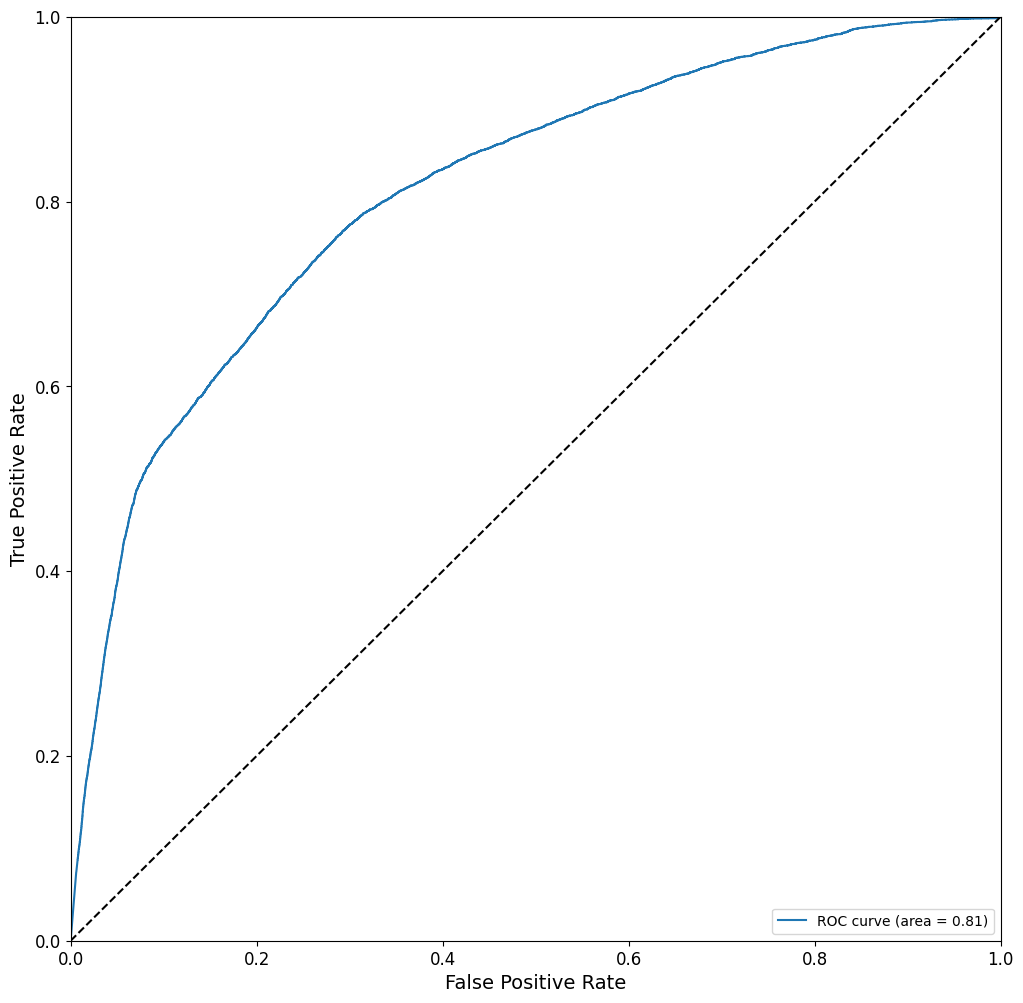

In [32]:
plt.figure(figsize = (12,12))
plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
fpr, tpr, _ = metrics.roc_curve(y_test_class, class_models['naive_bayes']['probs'])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % class_models['naive_bayes']['ROC_AUC_test'])
plt.plot([0, 1], [0, 1], 'k--')  # coin toss line
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

In [14]:
X_train_abbrev = X_train.iloc[:,[0, 1, 2, 4, 8, 9, 11, 17, 20]]
X_test_abbrev = X_test.iloc[:,[0, 1, 2, 4, 8, 9, 11, 17, 20]]
np.random.seed(rand)
sample_size = 0.1
sample_idx = np.random.choice(X_test.shape[0],\
                              math.ceil(X_test.shape[0]*sample_size), replace=False)

dimred_methods = {
        #Decomposition
        'pca':{'method': decomposition.PCA(n_components=3, random_state=rand)},  
        #Manifold Learning
        't-sne':{'method': manifold.TSNE(n_components=3, random_state=rand)},
        #Variational Autoencoders
        'vae':{'method': cvae.CompressionVAE(X_train_abbrev.values,\
                                             dim_latent=3, tb_logging=False)}, 
    }

Total amount of data:  688137
Input feature dimension:  9
Calculating normalisation factors.
Normalisation factors calculated.
Total amount of data:  76460
Creating model.
Model created.
Setting up loss.
Loss set up.
Setting up session.


2024-01-17 00:03:56.207010: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-17 00:03:56.208755: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-01-17 00:03:56.209248: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-01-17 00:03:56.231279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-17 00:03:56.231372: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce

Session set up.
Trying to restore saved checkpoints from /home/studio/바탕화면/ml/DelayFlight/temp ... No checkpoint found.
No model found to restore. Initialising new model.


In [16]:
for method_name in dimred_methods.keys():
    if method_name != 'vae':
        lowdim_data = dimred_methods[method_name]['method'].\
                        fit_transform(X_test_abbrev.values[sample_idx])
    else:
        fitted_model = dimred_methods[method_name]['method'].train(num_steps=1000)
        lowdim_data = fitted_model.embed(X_test_abbrev.values[sample_idx])
        dimred_methods[method_name]['fitted'] = fitted_model
    dimred_methods[method_name]['lowdim'] = lowdim_data

Starting queues.
Reader threads started.
step 0; epoch 0.00 - loss = 7.459, test_loss = 7.518, lr = 0.00100, (0.083 sec/step)
Storing checkpoint to /home/studio/바탕화면/ml/DelayFlight/temp ... Done.
step 50; epoch 0.00 - loss = 5.620, test_loss = 5.696, lr = 0.00100, (0.068 sec/step)
step 100; epoch 0.01 - loss = 5.680, test_loss = 4.763, lr = 0.00100, (0.064 sec/step)
step 150; epoch 0.01 - loss = 4.241, test_loss = 4.524, lr = 0.00100, (0.068 sec/step)
step 200; epoch 0.02 - loss = 4.575, test_loss = 4.495, lr = 0.00100, (0.064 sec/step)
step 250; epoch 0.02 - loss = 4.075, test_loss = 4.384, lr = 0.00100, (0.067 sec/step)
step 300; epoch 0.03 - loss = 2654610944.000, test_loss = 4.349, lr = 0.00100, (0.067 sec/step)
step 350; epoch 0.03 - loss = 3.805, test_loss = 4.342, lr = 0.00100, (0.064 sec/step)
step 400; epoch 0.04 - loss = 4.717, test_loss = 4.319, lr = 0.00100, (0.067 sec/step)
step 450; epoch 0.04 - loss = 3.841, test_loss = 4.302, lr = 0.00100, (0.064 sec/step)
step 500; epo

In [17]:
y_names = {0:'Not Delayed', 1:'Delayed'}

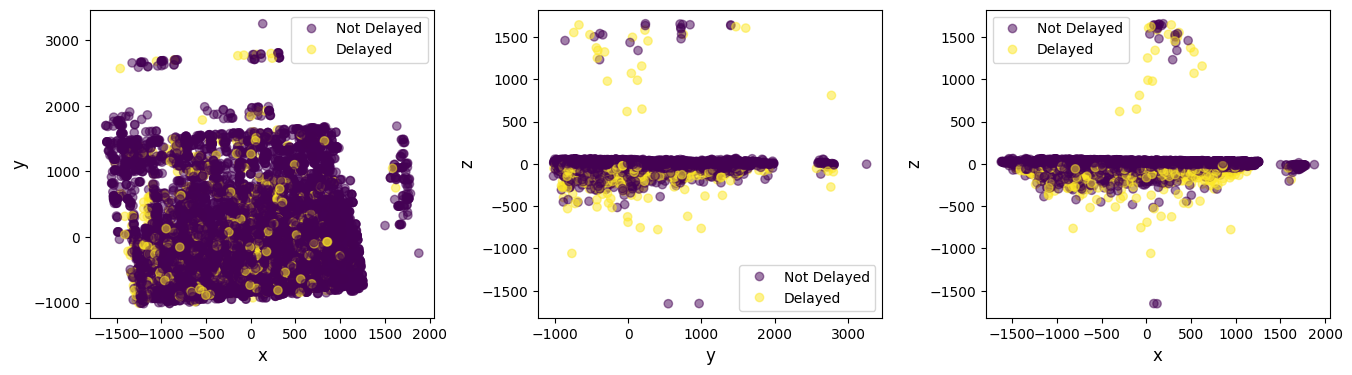

In [18]:
mldatasets.plot_3dim_decomposition(dimred_methods['pca']['lowdim'],\
                        y_test_class.values[sample_idx], y_names)

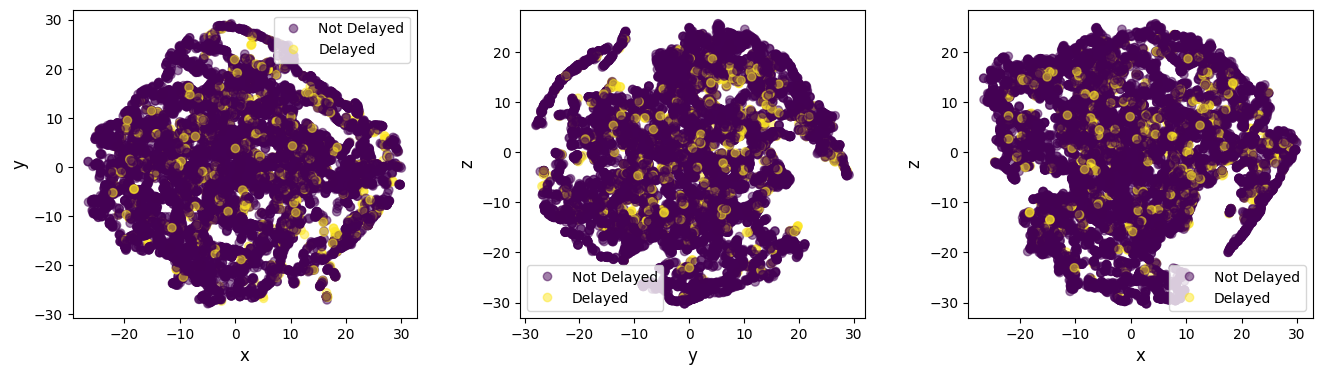

In [19]:
mldatasets.plot_3dim_decomposition(dimred_methods['t-sne']['lowdim'],\
                        y_test_class.values[sample_idx], y_names)

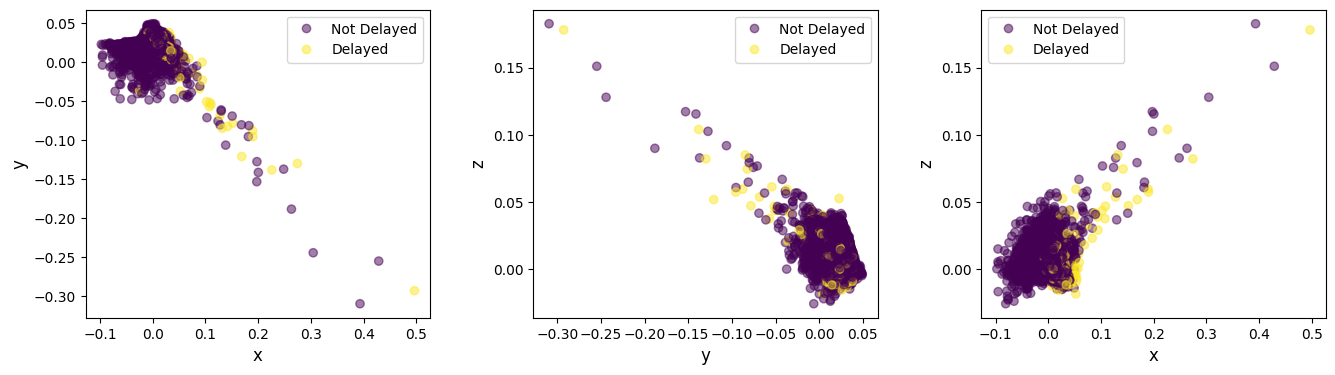

In [20]:
mldatasets.plot_3dim_decomposition(dimred_methods['vae']['lowdim'],\
                        y_test_class.values[sample_idx], y_names)

In [27]:
y_test_class_samp = y_test_class.values[sample_idx]
y_test_pred_samp = class_models['ridge']['preds'][sample_idx]
error_vector, error_labels = mldatasets.encode_classification_error_vector(y_test_class_samp, y_test_pred_samp)

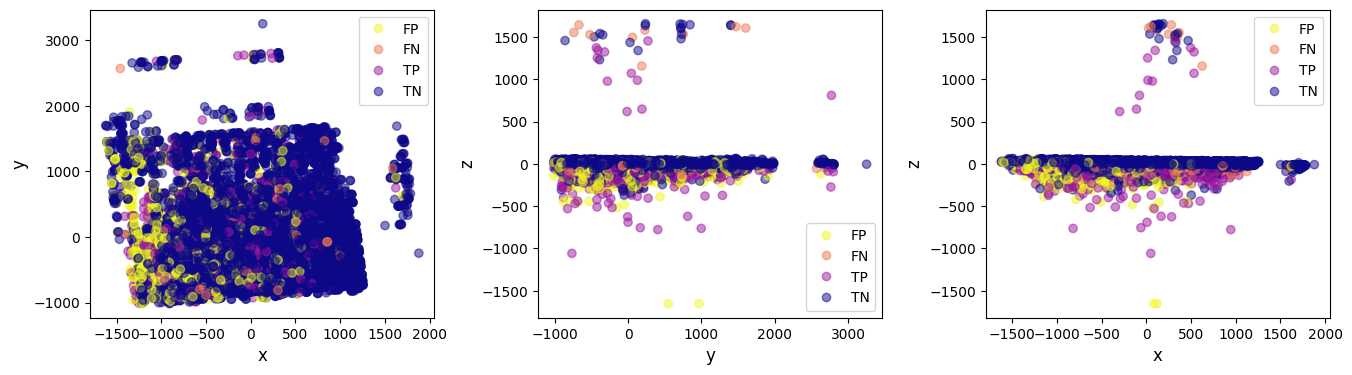

In [28]:
mldatasets.plot_3dim_decomposition(dimred_methods['pca']['lowdim'],\
                        error_vector, error_labels)

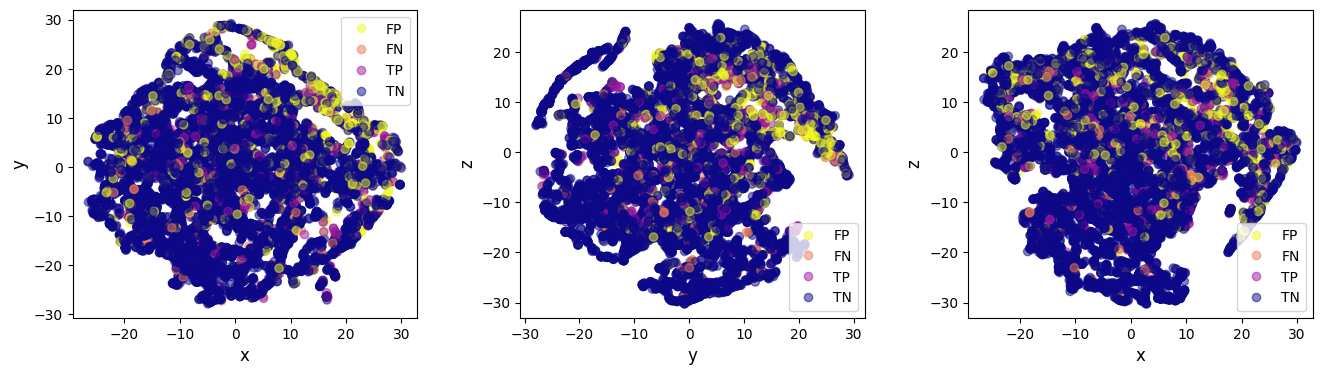

In [29]:
mldatasets.plot_3dim_decomposition(dimred_methods['t-sne']['lowdim'],\
                        error_vector, error_labels)

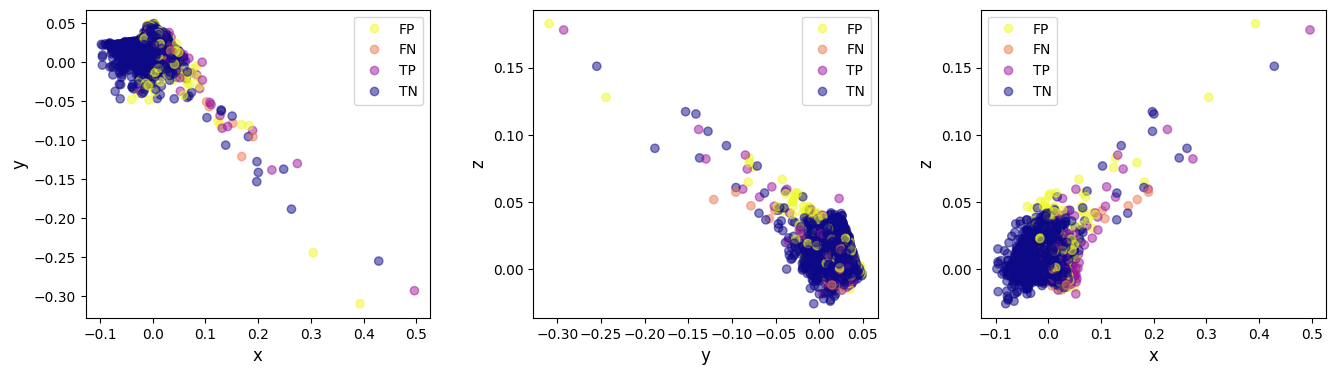

In [30]:
mldatasets.plot_3dim_decomposition(dimred_methods['vae']['lowdim'],\
                        error_vector, error_labels)

In [36]:
coefs_lm = reg_models['linear']['fitted'].coef_
intercept_lm = reg_models['linear']['fitted'].intercept_
print('coefficients:\t%s' % coefs_lm)
print('intercept:\t%s' % intercept_lm)

coefficients:	[ 4.54984539e-03 -5.25067742e-03  8.94125541e-01 -1.52961053e-02
 -4.69623002e-01  1.25277815e-01 -6.46744472e-04 -1.26240049e-02
  4.50112895e+01  6.76385421e-04 -3.69920254e-04  5.47855860e-04
  3.73866548e-01 -9.06364154e-01 -6.74052666e-01 -9.17411191e-01
 -9.29843952e-01 -3.96621856e-02 -1.79666480e-02 -1.02912927e+00
 -3.94934854e-01]
intercept:	-37.86177932752624


In [37]:
print('ŷ = %0.2f + %0.4fX₁ + %0.4fX₂ + %0.3fX₃ + ...' %\
      (intercept_lm, coefs_lm[0], coefs_lm[1], coefs_lm[2]))

ŷ = -37.86 + 0.0045X₁ + -0.0053X₂ + 0.894X₃ + ...


In [38]:
coef_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),\
                        'coef': coefs_lm})
print(coef_df)

                feature       coef
0          CRS_DEP_TIME   0.004550
1              DEP_TIME  -0.005251
2             DEP_DELAY   0.894126
3              DEP_AFPH  -0.015296
4              DEP_RFPH  -0.469623
5              TAXI_OUT   0.125278
6            WHEELS_OFF  -0.000647
7      CRS_ELAPSED_TIME  -0.012624
8      PCT_ELAPSED_TIME  45.011289
9              DISTANCE   0.000676
10         CRS_ARR_TIME  -0.000370
11             ARR_AFPH   0.000548
12             ARR_RFPH   0.373867
13        WEATHER_DELAY  -0.906364
14            NAS_DELAY  -0.674053
15       SECURITY_DELAY  -0.917411
16  LATE_AIRCRAFT_DELAY  -0.929844
17            DEP_MONTH  -0.039662
18              DEP_DOW  -0.017967
19           ORIGIN_HUB  -1.029129
20             DEST_HUB  -0.394935


In [39]:
linreg_mdl = sm.OLS(y_train_reg, sm.add_constant(X_train))
linreg_mdl = linreg_mdl.fit()
linreg_mdl.summary()

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          CARRIER_DELAY   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 4.251e+05
Date:                Wed, 17 Jan 2024   Prob (F-statistic):               0.00
Time:                        00:25:19   Log-Likelihood:            -2.6574e+06
No. Observations:              764597   AIC:                         5.315e+06
Df Residuals:                  764575   BIC:                         5.315e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -37.8618      0.125   -301.763      0.000     -38.108     -37.616
CRS_DEP_TIME            0.0045   7.24e-05     62.872      0.000       0.004       0.005
DEP_TIME               -0.0053   9.19e-05    -57.116      0.000      -0.005      -0.005
DEP_DELAY               0.8941      0.000   2951.056      0.000       0.894       0.895
DEP_AFPH               -0.0153      0.000    -47.725      0.000      -0.016      -0.015
DEP_RFPH               -0.4696      0.017    -27.353      0.000      -0.503      -0.436
TAXI_OUT                0.1253      0.001    104.120      0.000       0.123       0.128
WHEELS_OFF             -0.0006    6.7e-05     -9.646      0.000      -0.001      -0.001
CRS_ELAPSED_TIME       -0.0126      0.001    -19.132      0.000      -0.014      -0.011
PCT_ELAPSED_TIME       45.0113      0.117    384.073      0.000      44.782      45.241
DISTANCE                0.0007   8.02e-05      8.429      0.000       0.001       0.001
CRS_ARR_TIME           -0.0004   2.18e-05    -16.939      0.000      -0.000      -0.000
ARR_AFPH                0.0005      0.000      1.651      0.099      -0.000       0.001
ARR_RFPH                0.3739      0.013     28.386      0.000       0.348       0.400
WEATHER_DELAY          -0.9064      0.001   -995.366      0.000      -0.908      -0.905
NAS_DELAY              -0.6741      0.001   -829.129      0.000      -0.676      -0.672
SECURITY_DELAY         -0.9174      0.005   -167.857      0.000      -0.928      -0.907
LATE_AIRCRAFT_DELAY    -0.9298      0.001  -1827.018      0.000      -0.931      -0.929
DEP_MONTH              -0.0397      0.003    -15.019      0.000      -0.045      -0.034
DEP_DOW                -0.0180      0.004     -4.005      0.000      -0.027      -0.009
ORIGIN_HUB             -1.0291      0.027    -38.589      0.000      -1.081      -0.977
DEST_HUB               -0.3949      0.026    -15.041      0.000      -0.446      -0.343
==============================================================================
Omnibus:                   211121.387   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         24359701.834
Skew:                           0.098   Prob(JB):                         0.00
Kurtosis:                      30.651   Cond. No.                     5.69e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
summary_df = linreg_mdl.summary2().tables[1]
summary_df = summary_df.drop(['const']).reset_index().rename(columns={'index':'feature'})
summary_df['t_abs'] = abs(summary_df['t'])
summary_df.sort_values(by='t_abs', ascending=False).style.\
    background_gradient(cmap='plasma_r', low=0, high=0.1, subset=['P>|t|']).\
    background_gradient(cmap='plasma_r', low=0, high=0.1, subset=['t_abs'])

,feature,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],t_abs
2,DEP_DELAY,0.894126,0.000303,2951.055978,0.000000,0.893532,0.894719,2951.055978
16,LATE_AIRCRAFT_DELAY,-0.929844,0.000509,-1827.018082,0.000000,-0.930841,-0.928846,1827.018082
13,WEATHER_DELAY,-0.906364,0.000911,-995.366423,0.000000,-0.908149,-0.904579,995.366423
14,NAS_DELAY,-0.674053,0.000813,-829.128657,0.000000,-0.675646,-0.672459,829.128657
8,PCT_ELAPSED_TIME,45.011289,0.117195,384.072566,0.000000,44.781592,45.240987,384.072566
15,SECURITY_DELAY,-0.917411,0.005465,-167.857085,0.000000,-0.928123,-0.906699,167.857085
5,TAXI_OUT,0.125278,0.001203,104.119579,0.000000,0.122920,0.127636,104.119579
0,CRS_DEP_TIME,0.004550,0.000072,62.871693,0.000000,0.004408,0.004692,62.871693
1,DEP_TIME,-0.005251,0.000092,-57.115895,0.000000,-0.005431,-0.005070,57.115895
3,DEP_AFPH,-0.015296,0.000321,-47.724506,0.000000,-0.015924,-0.014668,47.724506


In [41]:
coefs_ridge = reg_models['ridge']['fitted'].coef_
coef_ridge_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),\
                        'coef_linear': coefs_lm,\
                        'coef_ridge': coefs_ridge})
coef_ridge_df.style.\
    background_gradient(cmap='viridis_r', low=0.3, high=0.2, axis=1)

,feature,coef_linear,coef_ridge
0,CRS_DEP_TIME,0.004550,0.004409
1,DEP_TIME,-0.005251,-0.005031
2,DEP_DELAY,0.894126,0.892909
3,DEP_AFPH,-0.015296,-0.015075
4,DEP_RFPH,-0.469623,-0.469627
5,TAXI_OUT,0.125278,0.125173
6,WHEELS_OFF,-0.000647,-0.000055
7,CRS_ELAPSED_TIME,-0.012624,-0.012624
8,PCT_ELAPSED_TIME,45.011289,45.011278
9,DISTANCE,0.000676,0.000762


In [42]:
num_alphas = 100
alphas = np.logspace(0, 13, num_alphas)
alphas_coefs = []
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha).fit(X_train, y_train_reg)
    alphas_coefs.append(np.concatenate((ridge.coef_[:8],ridge.coef_[9:])))

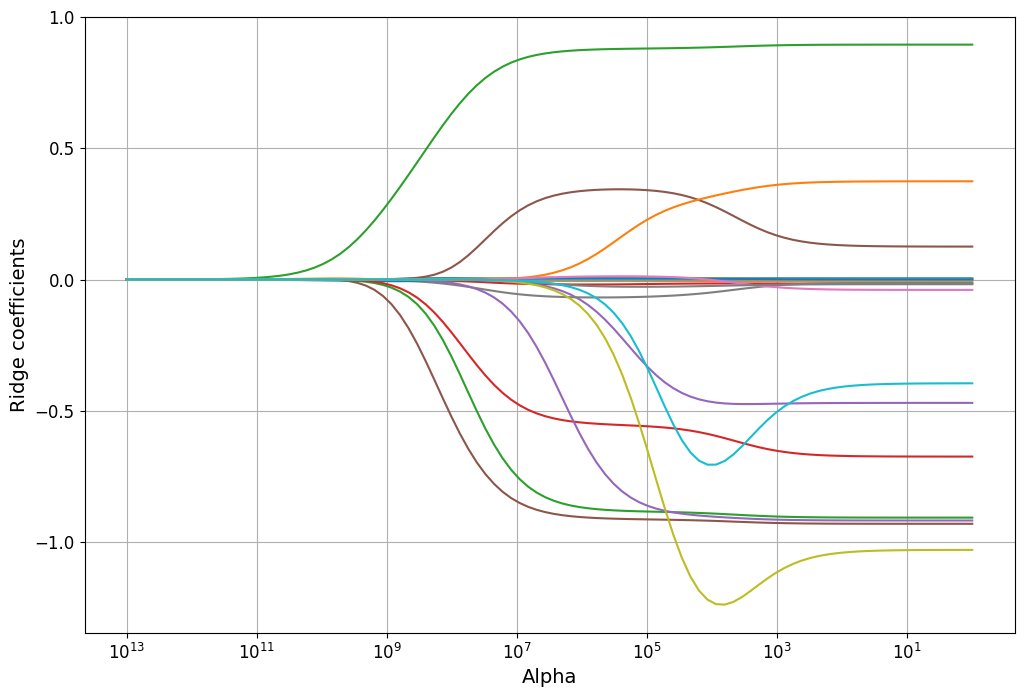

In [43]:
plt.figure(figsize = (12,8))
plt.gca().invert_xaxis()
plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.plot(alphas, alphas_coefs)
plt.xscale("log")
plt.xlabel('Alpha', fontsize = 14)
plt.ylabel('Ridge coefficients', fontsize = 14)
plt.grid()
plt.show()

In [44]:
print(reg_models['linear_poly']['fitted'].get_params()['linearregression'].coef_.shape[0])

253


In [45]:
print(reg_models['linear_interact']['fitted'].get_params()['linearregression'].coef_.shape[0])

232


In [46]:
coefs_log = class_models['logistic']['fitted'].coef_
intercept_log = class_models['logistic']['fitted'].intercept_
print('coefficients:\t%s' % coefs_log)
print('intercept:\t%s' % intercept_log)

coefficients:	[[-4.56475078e-04 -2.52967032e-04  1.98593354e-01 -4.32113810e-03
  -2.77997633e-01  1.27531987e-01  1.20545541e-05 -7.22565697e-02
  -4.50137485e-02  7.79633486e-03 -3.71483203e-04 -7.10008741e-03
  -6.28617542e-02 -2.04441426e-01 -1.69571047e-01 -2.28864600e-01
  -1.98573243e-01 -4.44691854e-02 -7.29976467e-02  3.99528327e-02
  -3.77341865e-01]]
intercept:	[-0.39965226]


In [47]:
stdv = np.std(X_train, 0)
abs(coefs_log.reshape(21,) * stdv).sort_values(ascending=False)

DEP_DELAY              8.790616
CRS_ELAPSED_TIME       5.735423
DISTANCE               5.063151
LATE_AIRCRAFT_DELAY    4.907076
NAS_DELAY              2.336696
WEATHER_DELAY          2.136360
TAXI_OUT               1.258637
SECURITY_DELAY         0.375137
ARR_AFPH               0.251082
CRS_DEP_TIME           0.228880
CRS_ARR_TIME           0.196193
DEST_HUB               0.183551
DEP_RFPH               0.157052
DEP_AFPH               0.153206
DEP_MONTH              0.151760
DEP_DOW                0.145879
DEP_TIME               0.130254
ARR_RFPH               0.045345
ORIGIN_HUB             0.019424
WHEELS_OFF             0.006227
PCT_ELAPSED_TIME       0.004741
dtype: float64

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


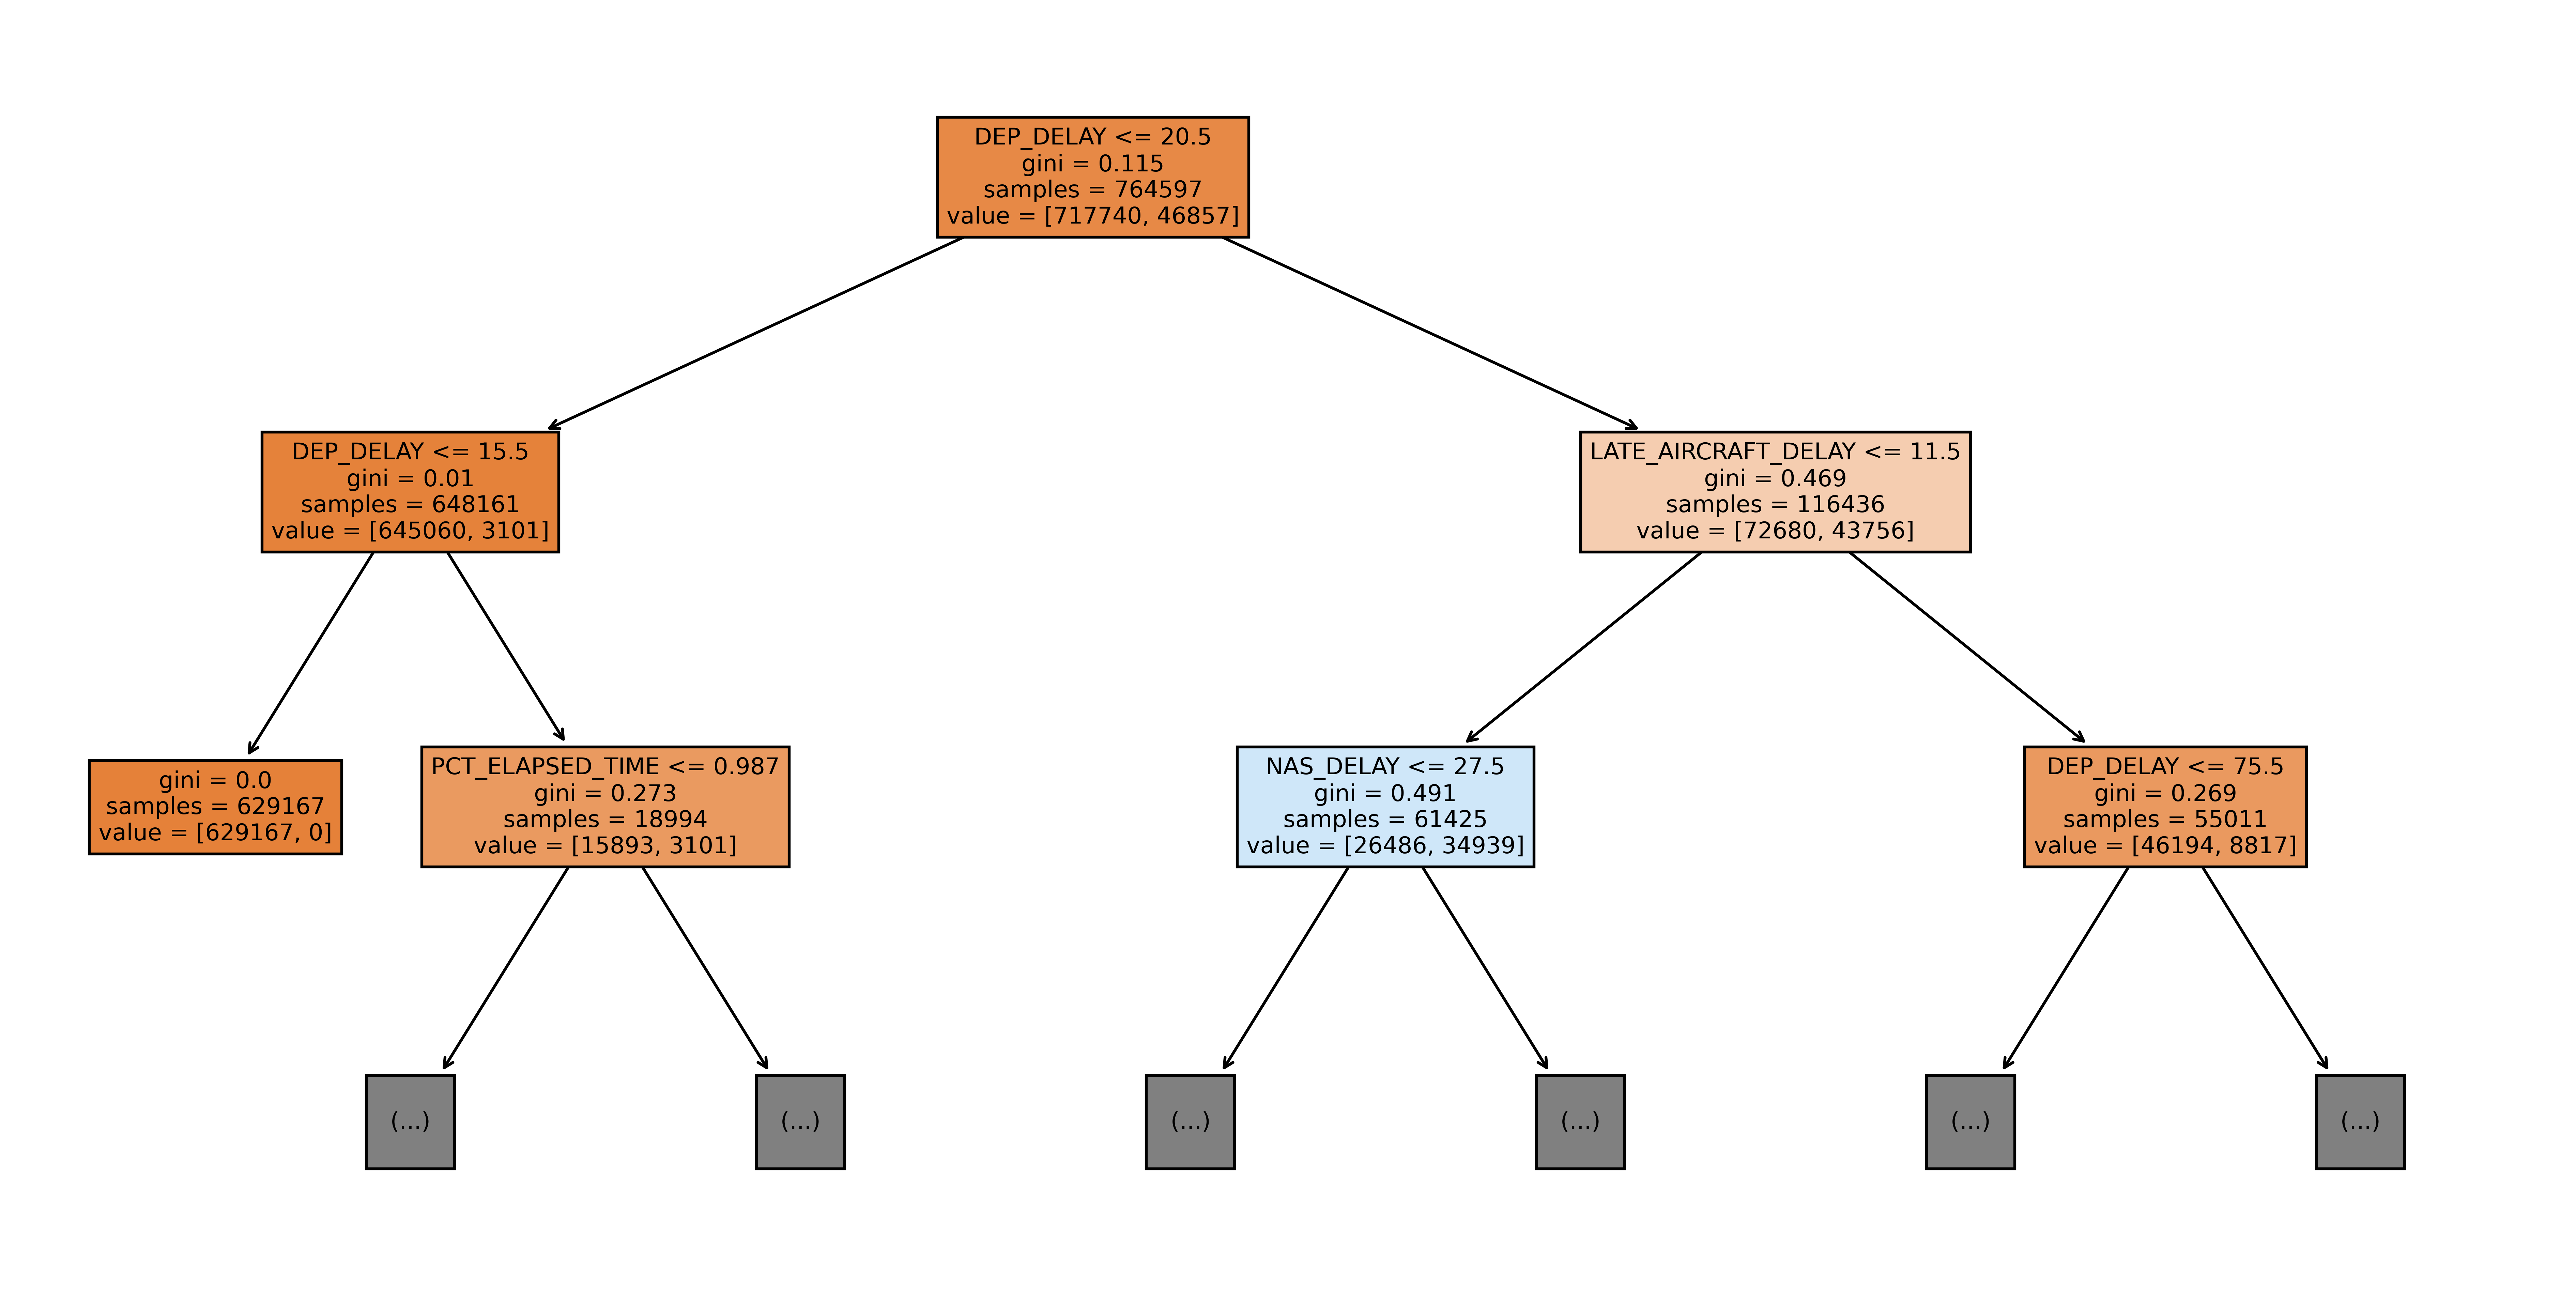

In [48]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16,8), dpi=600)
tree.plot_tree(class_models['decision_tree']['fitted'],\
               feature_names=X_train.columns.values.tolist(), filled = True, max_depth=2)
fig.show()

In [49]:
text_tree = tree.export_text(class_models['decision_tree']['fitted'],\
               feature_names=X_train.columns.values.tolist())
print(text_tree)

|--- DEP_DELAY <= 20.50
|   |--- DEP_DELAY <= 15.50
|   |   |--- class: 0
|   |--- DEP_DELAY >  15.50
|   |   |--- PCT_ELAPSED_TIME <= 0.99
|   |   |   |--- PCT_ELAPSED_TIME <= 0.98
|   |   |   |   |--- PCT_ELAPSED_TIME <= 0.96
|   |   |   |   |   |--- CRS_ELAPSED_TIME <= 65.50
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME <= 0.94
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME >  0.94
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- CRS_ELAPSED_TIME >  65.50
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME <= 0.95
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME >  0.95
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- PCT_ELAPSED_TIME >  0.96
|   |   |   |   |   |--- CRS_ELAPSED_TIME <= 140.50
|   |   |   |   |   |   |--- DEP_DELAY <= 18.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- DEP_DELAY >  18.50
|   |   |   |   |   |   |   |--- class: 0
|   |   

In [50]:
dt_imp_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),\
                        'importance': class_models['decision_tree']['fitted'].feature_importances_}).\
            sort_values(by='importance', ascending=False)
dt_imp_df

,feature,importance
2,DEP_DELAY,0.527482
16,LATE_AIRCRAFT_DELAY,0.199153
8,PCT_ELAPSED_TIME,0.105381
13,WEATHER_DELAY,0.101649
14,NAS_DELAY,0.062732
15,SECURITY_DELAY,0.001998
9,DISTANCE,0.001019
7,CRS_ELAPSED_TIME,0.000281
5,TAXI_OUT,0.000239
6,WHEELS_OFF,0.000035


In [51]:
rulefit_df = reg_models['rulefit']['fitted'].get_rules()
rulefit_df = rulefit_df[rulefit_df.coef != 0].sort_values(by="importance", ascending=False)
rulefit_df

,rule,type,coef,support,importance
59,LATE_AIRCRAFT_DELAY <= 222.5 & DEP_DELAY > 344...,rule,2.220725e+02,0.001684,9.104073e+00
91,DEP_DELAY > 477.5 & LATE_AIRCRAFT_DELAY <= 333.5,rule,1.725313e+02,0.001122,5.776771e+00
16,LATE_AIRCRAFT_DELAY,linear,-3.862887e-01,1.000000,4.526191e+00
2,DEP_DELAY,linear,1.636069e-01,1.000000,4.280381e+00
102,DEP_DELAY > 1206.0,rule,2.884097e+02,0.000187,3.944163e+00
...,...,...,...,...,...
99,DEP_DELAY > 218.5 & DEP_DELAY <= 477.5,rule,4.534805e-01,0.006173,3.551866e-02
52,LATE_AIRCRAFT_DELAY <= 22.0 & DEP_DELAY > 58.5...,rule,1.223451e-01,0.032735,2.177027e-02
18,DEP_DOW,linear,9.915958e-03,1.000000,1.981613e-02
129,DEP_DELAY <= 534.5 & DEP_DELAY <= 48.5,rule,-3.130352e-02,0.921811,8.404034e-03


In [52]:
print(X_test.loc[721043,:])

CRS_DEP_TIME            655.000000
DEP_TIME               1055.000000
DEP_DELAY               240.000000
DEP_AFPH                 90.800000
DEP_RFPH                  0.890196
TAXI_OUT                 35.000000
WHEELS_OFF             1130.000000
CRS_ELAPSED_TIME        259.000000
PCT_ELAPSED_TIME          1.084942
DISTANCE               1660.000000
CRS_ARR_TIME            914.000000
ARR_AFPH                 40.434783
ARR_RFPH                  1.064073
WEATHER_DELAY             0.000000
NAS_DELAY                22.000000
SECURITY_DELAY            0.000000
LATE_AIRCRAFT_DELAY     221.000000
DEP_MONTH                10.000000
DEP_DOW                   4.000000
ORIGIN_HUB                1.000000
DEST_HUB                  0.000000
Name: 721043, dtype: float64


In [53]:
print(y_test_class[721043])

1


In [54]:
print(y_test_class[721043])

1


In [55]:
print(class_models['knn']['preds'][X_test.index.get_loc(721043)])

0


In [56]:
print(class_models['knn']['fitted'].kneighbors(X_test.loc[721043,:].values.reshape(1,21), 7))

(array([[143.3160128 , 173.90740076, 192.66705727, 211.57109221,
        243.57211853, 259.61593993, 259.77507391]]), array([[105172, 571912,  73409,  89450,  77474, 705972, 706911]]))


In [57]:
print(y_train_class.iloc[[105172, 571912,  73409,  89450,  77474, 705972, 706911]])

3813      0
229062    1
283316    0
385831    0
581905    1
726784    1
179364    0
Name: CARRIER_DELAY, dtype: int64


In [58]:
print(class_models['knn']['fitted'].effective_metric_)

euclidean


In [59]:
print(class_models['naive_bayes']['fitted'].class_prior_)

[0.93871674 0.06128326]


In [60]:
print(class_models['naive_bayes']['fitted'].sigma_)

[[2.50123026e+05 2.61324730e+05 9.21572605e+02 1.26123968e+03
  2.08339528e-01 9.58074414e+01 2.62606651e+05 6.30102550e+03
  1.13475535e-02 4.22470414e+05 2.75433641e+05 1.25314386e+03
  3.48655340e-01 1.11234714e+02 1.91877186e+02 2.80302201e+00
  5.06561612e+02 1.17346654e+01 3.99122491e+00 2.39015406e-01
  2.34996222e-01]
 [2.60629652e+05 2.96009867e+05 1.19307931e+04 1.14839167e+03
  1.99929921e+00 1.20404927e+02 3.08568277e+05 6.29066219e+03
  1.38936741e-02 4.10198938e+05 3.28574000e+05 1.09023147e+03
  3.08997044e+00 7.79140423e+01 1.56184090e+02 9.12112286e-01
  2.11279954e+03 1.02712368e+01 4.02943162e+00 1.77750796e-01
  2.50208354e-01]]


In [61]:
print(class_models['naive_bayes']['fitted'].theta_)

[[1.30740577e+03 1.31006271e+03 5.14196506e+00 5.45864877e+01
  1.09377996e+00 1.87120810e+01 1.33552258e+03 1.70734929e+02
  9.71131781e-01 1.01824369e+03 1.48438931e+03 5.39873058e+01
  1.09644787e+00 7.39971299e-01 2.85434558e+00 2.41814585e-02
  4.14674395e+00 6.55045281e+00 2.95035528e+00 6.06800513e-01
  6.24199571e-01]
 [1.41305545e+03 1.48087887e+03 8.45867640e+01 6.14731036e+01
  1.25429654e+00 1.99378321e+01 1.49409412e+03 1.72229998e+02
  9.83974416e-01 1.04363666e+03 1.54821862e+03 4.26486417e+01
  1.36373798e+00 4.50733082e-01 4.71991378e+00 2.11281132e-02
  1.40744819e+01 6.73367907e+00 3.04251232e+00 7.69575517e-01
  4.85391724e-01]]


In [62]:
#Make new abbreviated versions of datasets
feature_samp = ['DEP_DELAY', 'LATE_AIRCRAFT_DELAY', 'PCT_ELAPSED_TIME', 'WEATHER_DELAY',\
                'NAS_DELAY', 'SECURITY_DELAY', 'DISTANCE', 'CRS_ELAPSED_TIME']
X_train_abbrev2 = X_train[feature_samp]
X_test_abbrev2 = X_test[feature_samp]
#For sampling among observations
np.random.seed(rand)
sample2_size = 0.1
sample2_idx = np.random.choice(X_train.shape[0], math.ceil(X_train.shape[0]*sample2_size), replace=False)

In [63]:
ebm_mdl = ExplainableBoostingClassifier()
ebm_mdl.fit(X_train_abbrev2.iloc[sample2_idx], y_train_class.iloc[sample2_idx])

ExplainableBoostingClassifier(early_stopping_rounds=50,
                              early_stopping_tolerance=0.0001, exclude=[],
                              feature_names=None, feature_types=None,
                              greediness=0.0, inner_bags=0, interactions=10,
                              learning_rate=0.01, max_bins=256,
                              max_interaction_bins=32, max_leaves=3,
                              max_rounds=5000, min_samples_leaf=2, n_jobs=-2,
                              objective='log_loss', outer_bags=8,
                              random_state=42, smoothing_rounds=0,
                              validation_size=0.15)

In [64]:
show(ebm_mdl.explain_global())

<!-- http://127.0.0.1:7001/140518517754384/ -->

In [65]:
ebm_lcl = ebm_mdl.explain_local(X_test_abbrev2.iloc[76:77],\
                                y_test_class[76:77], name='EBM')
show(ebm_lcl)

<!-- http://127.0.0.1:7001/140518512851472/ -->

In [66]:
ebm_perf = ROC(ebm_mdl.predict_proba).\
                            explain_perf(X_test_abbrev2.iloc[sample_idx],\
                                         y_test_class.iloc[sample_idx], name='EBM')
show(ebm_perf)

<!-- http://127.0.0.1:7001/140522627955984/ -->

In [67]:
sr_mdl = SkopeRules(n_estimators=200, precision_min=0.2, recall_min=0.01,\
                    n_jobs=-1, random_state=rand, max_depth=7,\
                    feature_names=X_train_abbrev2.columns)
sr_mdl.fit(X_train_abbrev2.iloc[sample2_idx], y_train_class.iloc[sample2_idx])

SkopeRules(bootstrap=False, bootstrap_features=False,
           feature_names=Index(['DEP_DELAY', 'LATE_AIRCRAFT_DELAY', 'PCT_ELAPSED_TIME', 'WEATHER_DELAY',
       'NAS_DELAY', 'SECURITY_DELAY', 'DISTANCE', 'CRS_ELAPSED_TIME'],
      dtype='object'),
           max_depth=7, max_depth_duplication=None, max_features=1.0,
           max_samples=0.8, max_samples_features=1.0, min_samples_split=2,
           n_estimators=200, n_jobs=-1, precision_min=0.2, random_state=9,
           recall_min=0.01, verbose=0)

In [68]:
sr_y_test_prob = sr_mdl.score_top_rules(X_test_abbrev2.iloc[sample_idx])
sr_y_test_pred = np.where(sr_y_test_prob > 0.5, 1, 0)

In [69]:
print(len(sr_mdl.rules_))

1517


In [70]:
print(sr_mdl.rules_[0:5])

[('DEP_DELAY > 39.5 and LATE_AIRCRAFT_DELAY <= 12.5 and WEATHER_DELAY <= 12.0 and NAS_DELAY <= 27.5 and SECURITY_DELAY <= 8.5', (0.959051724137931, 0.4777241009125067, 2)), ('DEP_DELAY > 39.5 and LATE_AIRCRAFT_DELAY <= 12.5 and WEATHER_DELAY <= 12.0 and NAS_DELAY <= 27.5 and SECURITY_DELAY <= 16.5', (0.9590878374516092, 0.4757740862307305, 6)), ('DEP_DELAY > 39.5 and LATE_AIRCRAFT_DELAY <= 11.5 and WEATHER_DELAY <= 12.0 and NAS_DELAY <= 27.5 and SECURITY_DELAY <= 20.5', (0.9598373709847126, 0.4728846642569354, 6)), ('DEP_DELAY > 39.5 and LATE_AIRCRAFT_DELAY <= 12.5 and WEATHER_DELAY <= 12.5 and NAS_DELAY <= 27.5 and SECURITY_DELAY <= 16.5', (0.9569012547735952, 0.4712520150456744, 2)), ('DEP_DELAY > 39.5 and LATE_AIRCRAFT_DELAY <= 11.5 and WEATHER_DELAY <= 12.0 and NAS_DELAY <= 27.5 and SECURITY_DELAY <= 19.0', (0.9589380988822661, 0.4700764303305863, 4))]


In [71]:
print('actual: %s, predicted: %s' % (y_test_class.iloc[76], sr_y_test_pred[76]))

actual: 1, predicted: 0


In [72]:
print(sr_mdl.decision_function(X_test_abbrev2.iloc[76:77]))

[18.23328729]


In [73]:
print('accuracy: %.3g, recall: %.3g, roc auc: %.3g, f1: %.3g, mcc: %.3g' %\
      (metrics.accuracy_score(y_test_class.iloc[sample_idx], sr_y_test_pred),\
       metrics.recall_score(y_test_class.iloc[sample_idx], sr_y_test_pred),\
       metrics.roc_auc_score(y_test_class.iloc[sample_idx], sr_y_test_prob),\
       metrics.f1_score(y_test_class.iloc[sample_idx], sr_y_test_pred),\
       metrics.matthews_corrcoef(y_test_class.iloc[sample_idx], sr_y_test_pred)))

accuracy: 0.961, recall: 0.981, roc auc: 0.984, f1: 0.748, mcc: 0.753
